<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#The-Data" data-toc-modified-id="The-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Data</a></span><ul class="toc-item"><li><span><a href="#Comparing-to-Other-Datasets" data-toc-modified-id="Comparing-to-Other-Datasets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparing to Other Datasets</a></span></li><li><span><a href="#Bimodal-Justification-—-Empirical-Distribution-Fitting" data-toc-modified-id="Bimodal-Justification-—-Empirical-Distribution-Fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Bimodal Justification — Empirical Distribution Fitting</a></span><ul class="toc-item"><li><span><a href="#Binned-Fitting" data-toc-modified-id="Binned-Fitting-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Binned Fitting</a></span></li></ul></li></ul></li><li><span><a href="#Motivation-—-Synthetic-Spectra-from-Hydrodynamic-Numerical-Models" data-toc-modified-id="Motivation-—-Synthetic-Spectra-from-Hydrodynamic-Numerical-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Motivation — Synthetic Spectra from Hydrodynamic Numerical Models</a></span></li><li><span><a href="#Asymmetry-Models" data-toc-modified-id="Asymmetry-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Asymmetry Models</a></span><ul class="toc-item"><li><span><a href="#Case-1:-One-Spherical-and-One-Asymmetric" data-toc-modified-id="Case-1:-One-Spherical-and-One-Asymmetric-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Case 1: One Spherical and One Asymmetric</a></span></li><li><span><a href="#Case-2:-All-Asymmetric" data-toc-modified-id="Case-2:-All-Asymmetric-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Case 2: All Asymmetric</a></span></li></ul></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Selection-Bias-Analysis" data-toc-modified-id="Selection-Bias-Analysis-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Selection Bias Analysis</a></span></li><li><span><a href="#Sampling-a-Uniform-Sphere-from-3D-to-2D" data-toc-modified-id="Sampling-a-Uniform-Sphere-from-3D-to-2D-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Sampling a Uniform Sphere from 3D to 2D</a></span></li></ul></li></ul></div>

The following report pertains to the paper (Keto Zhang, WeiKang Zheng, Thomas Brink, et al 20XX) from here on be called PAPER to be properly cited after publication.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9

np.random.seed(4282020)

In [3]:
sns.set(style='ticks', context='poster', color_codes=True)
plt.style.use("./style.mplstyle")
!cat style.mplstyle

figure.figsize: 10, 6
legend.fontsize: 18
lines.linewidth: 5
patch.linewidth: 2.2
hatch.linewidth: 2
xtick.direction: in
ytick.direction: in
xtick.minor.visible: True
ytick.minor.visible: True
xtick.minor.size: 7
ytick.minor.size: 7

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pathlib import Path
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm


def gaussian(x, mu=0, sigma=1, N=1):
    """Gaussian PDF

    Args:
        x (float or array_like): The x value to be evaluated.
        mu (float, optional): Expected value. Defaults to 0.
        sigma (float, optional): Standard deviation. Defaults to 1.
        N (int, optional): Area under the curve. If `N=1`, the function is a true probability density function. If `N>1`, the function is a number density function. Defaults to 1.

    Returns:
        float: The density at x. The density is either a probability density or number density depending on `N`.
    """
#     print('m', mu, 's', sigma, 'n', N)
    return N * norm.pdf(x, mu, sigma)


def bimodal_fit(x, guess_params, method="Nelder-Mead", **kwargs):
    """Un-normalized bimodial Gaussian fit on some data `x`"""
    N = len(x)
    
    def loss(params):
        mu1, sigma1, mu2, sigma2, n1 = params
        n1 = n1 / N
        prob1 = gaussian(x, mu1, sigma1)
        prob2 = gaussian(x, mu2, sigma2)
        prob = n1 * prob1 + (1 - n1) * prob2
        
        lnl = np.sum(np.log(prob))
        return -lnl

    result = minimize(loss, guess_params, method=method, **kwargs)
    return result


def multimodal_fit(x, guess_params, method="Nelder-Mead", **kwargs):
    """Un-normalized multimodal Gaussian fit on same data `x`

    Args:
        guess_params (array-like): Array with dimensions c x 3 where c is the number of Gaussian components and 3 represents mean, SD, and number parameter.
    """
    N = len(x)
    guess_params = np.array(guess_params)
    n_components = guess_params.shape[0]
    assert guess_params.shape[1] == 3

    def loss(params):
        params = params.reshape((n_components, 3))
        mu = params[:, 0]
        sd = params[:, 1]
        n = params[:, 2]
        n = n / np.sum(n)

        # (N,) array where each column represent the component probability
        prob = (n * gaussian(np.array([x for i in range(n_components)]).T, mu,
                             sd, np.ones(n_components))).sum(axis=1)
        lnl = np.sum(np.log(prob))
        return -lnl

    result = minimize(loss, guess_params, method=method, **kwargs)
    return result


from dataloader import import_kaepora

PROJECT_PATH = Path('.').resolve().parent
RESULTS_PATH = PROJECT_PATH / "results"
np.random.seed(822)

# Replace data with this for a sanity check
# data = np.hstack(
#     (
#         norm.rvs(loc=10000, scale=700, size=10000),
#         norm.rvs(loc=15000, scale=200, size=10000),
#     )
# )
data = import_kaepora()["v_siII"]

result = bimodal_fit(np.array(data), [11000, 700, 14000, 1200, 200])
fitted_params = result.x
print(result.message)
print(-result.fun, [f"{p:.2f}" for p in fitted_params])

guess_params = [
    [11000, 1000, 1/4], [14000, 1000, 1/4], [12000, 1000, 2/4]
]
result = multimodal_fit(np.array(data), guess_params)
fitted_params = result.x
print(result.message)
print(-result.fun, fitted_params.reshape((3, 3)))


Optimization terminated successfully.
-2647.7798300188897 ['10999.69', '693.10', '12312.44', '1777.63', '200.99']
Maximum number of function evaluations has been exceeded.
-2647.6392634807517 [[ 1.22629345e+04  8.11875383e+02 -2.54859845e-02]
 [ 1.23062820e+04  1.79441263e+03  2.41388094e-01]
 [ 1.10229334e+04  7.08200712e+02  4.29561131e-01]]


# Introduction



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocity (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocity observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore we decided MCMC was too time consuming. Parameter estimation was descoped from MCMC to grid search which provides a single set of best estimated parameters which would produced a smaller posterior population than if MCMC was used.


# The Data

The dataset comes from the kaepora database ([Siebert, M. R. et al. 2019](https://academic.oup.com/mnras/article/486/4/5785/5484870)). It consists of 311 Si II velocity from SNe Ia.

Justification for this dataset over others were discussed on the PAPER and analyzed here on the next subsection.

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


,v_siII,v_siII_err,z
count,311.000000,302.000000,291.000000
mean,11464.053312,252.692500,0.022419
std,1352.070748,48.301207,0.014516
min,7359.470000,220.440000,0.000677
25%,10635.450000,222.689500,0.012223
50%,11234.900000,233.762500,0.019900
75%,11998.850000,260.649250,0.030912
max,15969.300000,616.588000,0.079665


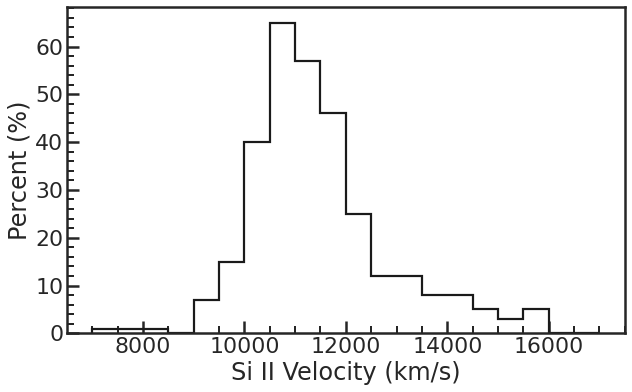

In [6]:
from dataloader import import_kaepora  # See dataloader.py::clean_data for data cleaning process

data = import_kaepora()

# Plot
bins = np.arange(7000, 17001, 500)
plt.hist(data['v_siII'],
         bins=bins,
         color='k',
         histtype='step',
         label='Observed')

# Plot config
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Percent (%)')

display(data.head())
display(data.describe())

plt.savefig(
    'results/velocity_dist_raw.eps',
    orientation='landscape',
    format='eps',
)

Text(0, 0.5, 'Percent (%)')

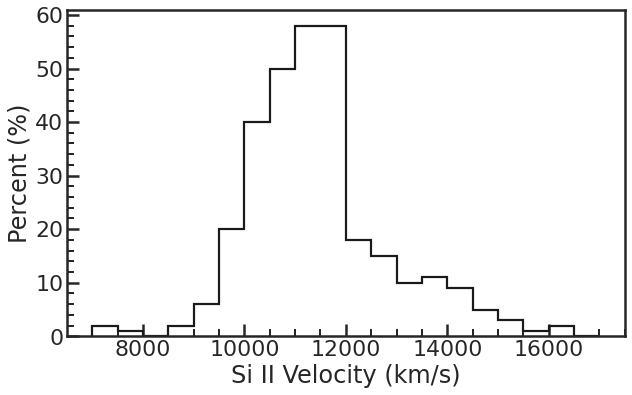

In [7]:
from scipy.stats import norm

data['v_siII_err_modified'] = data['v_siII_err'].fillna(data['v_siII_err'].min())

# Plot
bins = np.arange(7000, 17001, 500)
plt.hist(norm.rvs(size=len(data), loc=data['v_siII'].values, scale=data['v_siII_err_modified'].values)
,
         bins=bins,
         color='k',
         histtype='step',
         label='Observed')

# Plot config
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Percent (%)')

In [8]:
data.describe()

,v_siII,v_siII_err,z,v_siII_err_modified
count,311.000000,302.000000,291.000000,311.000000
mean,11464.053312,252.692500,0.022419,251.759148
std,1352.070748,48.301207,0.014516,47.901986
min,7359.470000,220.440000,0.000677,220.440000
25%,10635.450000,222.689500,0.012223,222.453000
50%,11234.900000,233.762500,0.019900,233.198000
75%,11998.850000,260.649250,0.030912,259.957000
max,15969.300000,616.588000,0.079665,616.588000


## Comparing to Other Datasets

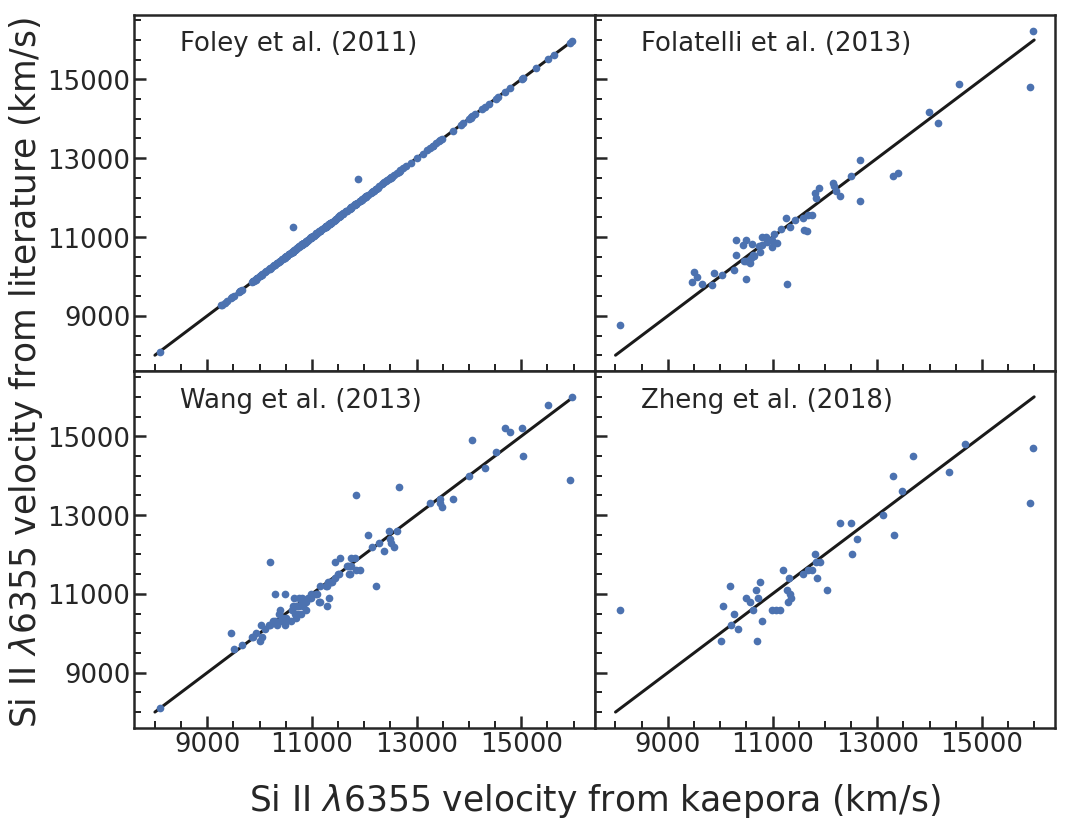

In [19]:
from dataloader import import_folatelli13, import_foley11, import_wang13, import_zheng18

datasets = [
    import_foley11(),
    import_folatelli13(),
    import_wang13(),
    import_zheng18()
]
labels = [
    'Foley et al. (2011)',
    'Folatelli et al. (2013)', 
    'Wang et al. (2013)',
    'Zheng et al. (2018)', 
]

# Plot
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows,
                        ncols,
                        figsize=(8 * ncols, 6 * nrows),
                        sharex=True,
                        sharey=True)
ticks = np.arange(9000, 16001, 2000)

for i in range(nrows * ncols):
    ax = axs[i // ncols, i % ncols]
    d = datasets[i]
    overlap = set(data.index).intersection(set(datasets[i].index))

    # 45deg line
    ax.plot([8000, 16000], [8000, 16000], 'k', linewidth=3, zorder=1)

    ax.scatter(data.loc[overlap, 'v_siII'],
               d.loc[overlap, 'v_siII'],
               s=30,
               zorder=2)
    ax.text(x=0.1, y=0.9, s=f'{labels[i]}', transform=ax.transAxes, fontsize=26)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=26)

# Outer Element
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                which='both',
                top=False,
                bottom=False,
                left=False,
                right=False)

plt.xlabel('Si II $\lambda$6355 velocity from kaepora (km/s)', fontsize='x-large', labelpad=30)
plt.ylabel('Si II $\lambda$6355 velocity from literature (km/s)', fontsize='x-large', labelpad=50)

plt.tight_layout(pad=0)
plt.savefig('results/overlap_data.eps', orientation='landscape', format='eps')

In [9]:
!python dataloader.py

Wang13 Size: 164
Folatelli13 Size: 78
Foley11 Size: 250
Zheng18 Size: 54
kaepora Size: 311
Total Dataset Size (w/o kaepora): 356
Total Dataset Size: 395
KAEPORA Overlap Size: 272


## Bimodal Justification &mdash; Empirical Distribution Fitting

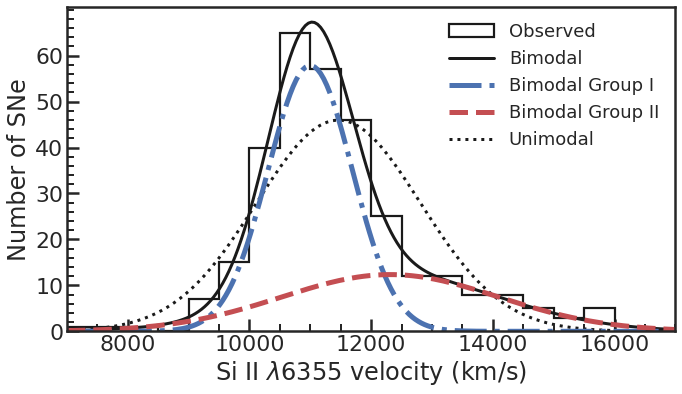

In [10]:
from models import gaussian, bimodal_gaussian

# See models.py::main for fitting procedure
UNIMODAL_PARAMS = np.loadtxt('results/unimodal_params.csv', delimiter=',')
BIMODAL_PARAMS = np.loadtxt('results/bimodal_params.csv', delimiter=',')

x = data['v_siII']
N = len(x)
bins = np.arange(7000, 17001, 500)
bin_width = np.mean(bins[1:] - bins[:-1])
xrange = np.linspace(bins.min(), bins.max(), 200)
hist = plt.hist(x, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
plt.plot(xrange, N*bin_width*gaussian(xrange, *UNIMODAL_PARAMS), 'k', linestyle='dotted', linewidth=3, zorder=0, label='Unimodal')

# Bimodal Gaussian
g1 = BIMODAL_PARAMS[4]
lv_dist = g1 * gaussian(xrange, *BIMODAL_PARAMS[0:2])
hv_dist = (1-g1) * gaussian(xrange, *BIMODAL_PARAMS[2:4])
plt.plot(xrange, N*bin_width*(lv_dist + hv_dist), 'k', linewidth=3, zorder=0, label='Bimodal')
plt.plot(xrange, N*bin_width*lv_dist, 'b', linestyle='dashdot', zorder=1, label='Bimodal Group I')
plt.plot(xrange, N*bin_width*hv_dist, 'r', linestyle='dashed', zorder=1, label='Bimodal Group II')

# Plot config
plt.xlim(bins.min(), bins.max())
plt.yticks(np.arange(0, np.round(hist[0].max(), 1), 10))

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel('Number of SNe')
handles, labels = ax.get_legend_handles_labels()
handles, legends = plt.gca().get_legend_handles_labels()
order = [4, 1, 2, 3, 0]
plt.legend([handles[i] for i in order], [legends[i] for i in order], frameon=False, loc='upper right', handlelength=2.5)

plt.tight_layout()
plt.savefig('results/velocity_dist.eps', orientation='landscape', format='eps', )

The bayes desicision rule places the bounds at 9300 and 12000 where the center region favors group I and the outer regions favors group II.

In [11]:
def unimodal_lnlike(x, params):
    mu, sigma = params
    prob = gaussian(x, mu, sigma)
    lnl = sum(np.log(prob))
    return lnl



def bimodal_lnlike(x, params):
    mu1, sigma1, mu2, sigma2, g = params
    prob1 = gaussian(x, mu1, sigma1)
    prob2 = gaussian(x, mu2, sigma2)
    prob = g * prob1 + (1 - g) * prob2
    lnl = sum(np.log(prob))
    return lnl

def bic(lnl, nparams, nsamples):
    return nparams * np.log(nsamples) - 2 * lnl

def aic(lnl, nparams):
    return 2  * nparams - 2 * lnl


def aicc(lnl, n, nparams):
    c = (2*nparams**2 + 2*nparams) / (n - nparams - 1)
    return aic(lnl, nparams) + c

# Best Fit Parameters
_ = pd.DataFrame([UNIMODAL_PARAMS, BIMODAL_PARAMS], columns=['$\mu_1$', '$\sigma_1$', '$\mu_2$', '$\sigma_2$', '$g$'], index=['Unimodal', 'Bimodal'])
display(_)


# Performance Metrics
unimodal_lnl = unimodal_lnlike(data['v_siII'], UNIMODAL_PARAMS)
bimodal_lnl = bimodal_lnlike(data['v_siII'], BIMODAL_PARAMS)
_ = pd.DataFrame(
    [
        [unimodal_lnl, -2*unimodal_lnl, aicc(unimodal_lnl, 3, len(data))],
        [bimodal_lnl, -2*bimodal_lnl, aicc(bimodal_lnl, 5, len(data))],
    ],
    columns=['Log-Likelihood', '$\chi^2$', 'AICc'],
    index=['Unimodal', 'Bimodal']
)

diff = _.loc['Unimodal', :] - _.loc['Bimodal', :]
diff.name = 'Difference'
_ = _.append(diff)
display(_)

print(bic(unimodal_lnl, 3, len(data)), bic(bimodal_lnl, 3, len(data)), bic(unimodal_lnl, 3, len(data)) - bic(bimodal_lnl, 3, len(data)))

,$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
Unimodal,11464.053312,1349.895251,NaN,NaN,NaN
Bimodal,10999.685302,693.101891,12312.438942,1777.630832,0.646264


,Log-Likelihood,$\chi^2$,AICc
Unimodal,-2682.910172,5365.820344,5359.781509
Bimodal,-2647.779830,5295.559660,5285.429367
Difference,-35.130342,70.260683,74.352142


5383.03972226955 5312.779038774316 70.26068349523393


In [12]:
from models import gaussian_cdf, bimodal_gaussian_cdf

v_12000 = np.append(1-gaussian_cdf(12000, *BIMODAL_PARAMS[0:2]), 1-gaussian_cdf(12000, *BIMODAL_PARAMS[2:4]))
v_13000 = np.append(1-gaussian_cdf(13000, *BIMODAL_PARAMS[0:2]), 1-gaussian_cdf(13000, *BIMODAL_PARAMS[2:4]))
v_9500 = np.append(gaussian_cdf(9500, *BIMODAL_PARAMS[0:2]), gaussian_cdf(9500, *BIMODAL_PARAMS[2:4]))

pd.DataFrame(
    [
        [*v_12000/np.sum(v_12000), np.sum(data['v_siII'] > 12000)],
        [*v_13000/np.sum(v_13000), np.sum(data['v_siII'] > 13000)],
        [*v_9500/np.sum(v_9500), np.sum(data['v_siII'] <= 9500)]
    ],
    index=['Prob(v > 12000)', 'Prob(v > 13000)', 'Prob(v <= 9500)'],
    columns=['Group I', 'Group II', 'Data Count']
)


,Group I,Group II,Data Count
Prob(v > 12000),0.115604,0.884396,78
Prob(v > 13000),0.005551,0.994449,41
Prob(v <= 9500),0.211547,0.788453,10


$\chi^2$ in the "Difference" row is the likelihood ratio $\chi^2$ statistics derived from the likelihood values. The number of degrees of freedom is the difference in the number of free parameters between the bimodal and unimodal model (i.e., 3). Because $\chi^2_3 > 7.82$ (p-value < 5%), we consider the improvement from the unimodal to the bimodal fit to be significant. The AICc provides a metric that penalizes the number of parameters and small sample size to prevent overfitting. Because the $\text{AICc} > 6$, we consnider the improvement to be very significant.

In [13]:
_ = pd.DataFrame([
    np.array([unimodal_lnl, *UNIMODAL_PARAMS]),
    np.array([bimodal_lnl, *BIMODAL_PARAMS])
],
    columns = [r"$L_\text{max}$", "$\mu_1$", "$\sigma_1$", "$\mu_2$", "$\sigma_2$", "$g$",]
)

_.style.format(("{:#.0f}"))

,$L_\text{max}$,$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
0,-2683.,11464.,1350.,nan,nan,nan
1,-2648.,11000.,693.,12312.,1778.,1.


### Binned Fitting

As a sanity check to maximum likelihood, midpoint values of binned data was fitted using ordinary least squares.

[11090.59059388   967.07001964] [1.09761909e+04 7.64854074e+02 1.31763576e+04 1.37814468e+03
 7.58457809e-01]


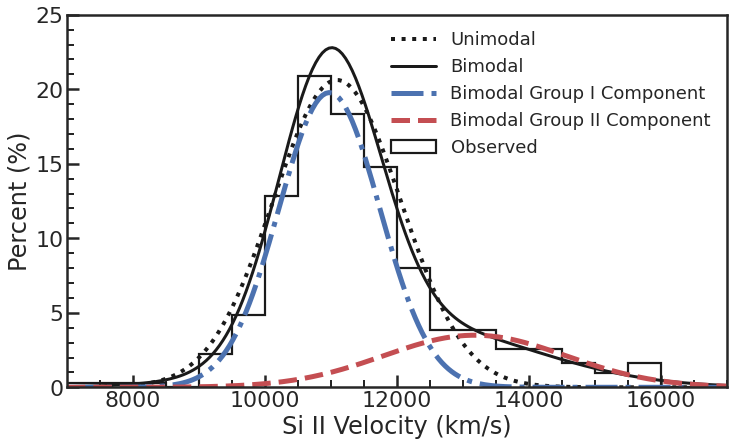

In [14]:
# See models.py::main for binned fitting procedure
BINNED_UNIMODAL_PARAMS = np.loadtxt('results/binned_unimodal_params.csv', delimiter=',')
BINNED_BIMODAL_PARAMS = np.loadtxt('results/binned_bimodal_params.csv', delimiter=',')
print(BINNED_UNIMODAL_PARAMS, BINNED_BIMODAL_PARAMS)

x = data['v_siII']
bins = np.arange(7000, 17001, 500)
plt.hist(x, density=True, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
plt.plot(xrange, gaussian(xrange, *BINNED_UNIMODAL_PARAMS), 'k', linestyle='dotted', linewidth=4, zorder=0, label='Unimodal')

# Bimodal Gaussian
g1 = BINNED_BIMODAL_PARAMS[4]
## Group I
lv_dist = g1 * gaussian(xrange, *BINNED_BIMODAL_PARAMS[0:2])
plt.plot(xrange, lv_dist + hv_dist, 'k', linewidth=3, zorder=0, label='Bimodal')
## Group II
hv_dist = (1-g1) * gaussian(xrange, *BINNED_BIMODAL_PARAMS[2:4])
## Group I + Group II
plt.plot(xrange, lv_dist, 'b', linestyle='dashdot', zorder=1, label='Bimodal Group I Component')

plt.plot(xrange, hv_dist, 'r', linestyle='dashed', zorder=1, label='Bimodal Group II Component')

# Plot config
plt.xlim(bins.min(), bins.max())
plt.ylim(0, 25 / 500 / 100)

yticks = plt.yticks()[0] * 500 * 100
ytickslabel = [f'{tick:.2g}' for tick in yticks]
plt.yticks(plt.yticks()[0], ytickslabel)

plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Percent (%)')
plt.legend(loc='upper right', frameon=False, fontsize=18, handlelength=2.5)

# Save results
plt.tight_layout(pad=0)
plt.savefig('results/binned_velocity_dist.eps', orientation='landscape', format='eps', )

Calculating the chi-square statistics for the binned fitting,

In [15]:
from models import gaussian_cdf, bimodal_gaussian_cdf

# def chi2_statistics(observed_count, expected_count):
#     summand = (observed_count - expected_count)**2 / expected_count
#     dof = len(observed_count) - nparams
#     return np.sum(summand)
def pearson_chi2_statistics(y, y_pred):
    summand = (observed_count - expected_count)**2 / expected_count
    return np.sum(summand)

def display_chi2_table(save_as=None):
    df = pd.DataFrame(
        [bins[:-1], bins[1:], observed_count, expected_count, observed_count - expected_count, (observed_count - expected_count)**2 / expected_count],
        index=["Bin (Left)", "Bin (Right)", "Observed Count O", "Expected Count E", "Difference E-O", "(O-E)**2 / E"]
    ).T
    
    df.loc[0, 'Bin (Left)'] = -np.inf
    df.loc[len(df)-1, 'Bin (Right)'] = np.inf
    display(df)

bins = np.arange(9000, 13500+1, 500)
observed_count, _= np.histogram(data['v_siII'], bins=bins)
observed_count[1] += np.sum(observed_count < bins[1])
observed_count[-2] += np.sum(observed_count < bins[-2])
bin_midpoints = (bins[1:] + bins[:-1]) / 2
bin_width = np.mean(bin_midpoints[1:] - bin_midpoints[:-1])

# Unimodal Gaussian
expected_count = np.sum(observed_count) * bin_width * gaussian(bin_midpoints, *BINNED_UNIMODAL_PARAMS)
left_count = gaussian_cdf(bins[1], *BINNED_UNIMODAL_PARAMS)
right_count = 1 - gaussian_cdf(bins[-2], *BINNED_UNIMODAL_PARAMS)
expected_count[0] += left_count
expected_count[-1] += right_count
unimodal_chi2 = pearson_chi2_statistics(observed_count, expected_count)
display_chi2_table()

# Bimodal Gaussian
expected_count = np.sum(observed_count) * bin_width * bimodal_gaussian(bin_midpoints, *BINNED_BIMODAL_PARAMS)
left_count = bimodal_gaussian_cdf(bins[1], *BINNED_BIMODAL_PARAMS)
right_count = 1 - bimodal_gaussian_cdf(bins[-2], *BINNED_BIMODAL_PARAMS)
expected_count[0] += left_count
expected_count[-1] += right_count
bimodal_chi2 = pearson_chi2_statistics(observed_count, expected_count)
display_chi2_table()

_ = pd.DataFrame([
    np.array([unimodal_chi2, unimodal_chi2/(len(bins)-2), len(bins)-2, *BINNED_UNIMODAL_PARAMS, None, None, None]),
    np.array([bimodal_chi2, bimodal_chi2/(len(bins)-5), len(bins)-5, *BINNED_BIMODAL_PARAMS])
],
                 columns=[
                     "$\chi^2$",
                     "$\chi^2 / d$",
                     "d (DOF)",
                     "$\mu_1$",
                     "$\sigma_1$",
                     "$\mu_2$",
                     "$\sigma_2$",
                     "$g$",
                 ])
_

,Bin (Left),Bin (Right),Observed Count O,Expected Count E,Difference E-O,(O-E)**2 / E
0,-inf,9500.0,7.0,10.097102,-3.097102,0.949979
1,9500.0,10000.0,24.0,23.515559,0.484441,0.009980
2,10000.0,10500.0,40.0,42.128558,-2.128558,0.107546
3,10500.0,11000.0,65.0,57.770248,7.229752,0.904779
4,11000.0,11500.0,57.0,60.637072,-3.637072,0.218155
5,11500.0,12000.0,46.0,48.716777,-2.716777,0.151506
6,12000.0,12500.0,25.0,29.958856,-4.958856,0.820801
7,12500.0,13000.0,21.0,14.101920,6.898080,3.374257
8,13000.0,inf,13.0,5.105031,7.894969,12.209628


,Bin (Left),Bin (Right),Observed Count O,Expected Count E,Difference E-O,(O-E)**2 / E
0,-inf,9500.0,7.0,4.818651,2.181349,0.987473
1,9500.0,10000.0,24.0,16.779758,7.220242,3.106833
2,10000.0,10500.0,40.0,38.651063,1.348937,0.047078
3,10500.0,11000.0,65.0,58.634842,6.365158,0.690975
4,11000.0,11500.0,57.0,59.208863,-2.208863,0.082404
5,11500.0,12000.0,46.0,41.431571,4.568429,0.503735
6,12000.0,12500.0,25.0,23.040074,1.959926,0.166723
7,12500.0,13000.0,21.0,13.935797,7.064203,3.580919
8,13000.0,inf,13.0,11.249632,1.750368,0.272346


,$\chi^2$,$\chi^2 / d$,d (DOF),$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
0,18.746631,2.343329,8.0,11090.590594,967.070020,NaN,NaN,NaN
1,9.438486,1.887697,5.0,10976.190928,764.854074,13176.357591,1378.144678,0.758458


# Motivation &mdash; Synthetic Spectra from Hydrodynamic Numerical Models

,$\theta_c$,$\sigma$,$v_c$,$\sigma$,$\Delta_v$,$\sigma$
Kasen et al.,99.530773,8.070400,11723.807709,202.738806,5684.086737,988.641820
Townsley et al.,98.018631,3.653168,11113.082711,111.565640,5226.785506,427.139156


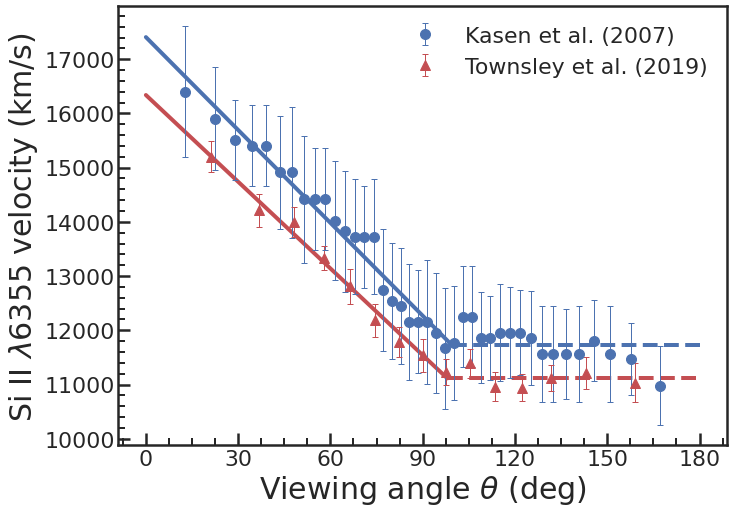

In [16]:
from dataloader import import_kasen07, import_townsley19
from scipy.optimize import curve_fit

kasen_model = import_kasen07()
townsley_model = import_townsley19()


def piecewise_linear(x, x0, y0, m1):
    l1 = (m1 * x) + (y0 - (m1 * x0))
    l2 = y0

    return np.choose(x <= x0, [l2, l1])


def quadrature(x, y):
    return np.sqrt(x**2 + y**2)


def multiply_uncertainty(x, dx, y, dy):
    z = x * y
    dz = np.abs(z * quadrature(dx / x, dy / y))
    return dz


x = np.linspace(0, 180, 1000)
fig = plt.figure(figsize=(10, 7))

# Kasen et al. (2007)
plt.errorbar(kasen_model['viewing_angle'],
             kasen_model['v_siII'],
             yerr=kasen_model['v_siII_err'],
             fmt='o',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             zorder=2,
             label='Kasen et al. (2007)')
params, _ = curve_fit(piecewise_linear,
                      kasen_model['viewing_angle'],
                      kasen_model['v_siII'],
                      sigma=kasen_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
errors = np.sqrt(np.diag(_))
kasen_results = pd.DataFrame([[
    params[0], errors[0], params[1], errors[1], -params[2] * params[0],
    multiply_uncertainty(params[0], errors[0], params[2], errors[2])
]],
                             columns=[
                                 r"$\theta_c$",
                                 '$\sigma$',
                                 "$v_c$",
                                 '$\sigma$',
                                 "$\Delta_v$",
                                 '$\sigma$',
                             ],
                             index=["Kasen et al."])
kasen_errors = pd.DataFrame(
    [errors],
    columns=[r"$\theta_c$", "$v_c$", "$\Delta_v$"],
    index=["Kasen et al."],
)

plt.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='b',
         lw=4,
         zorder=1)
plt.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='b',
         lw=4,
         zorder=1,
         ls='--')

# Townsley et al. (2019)
plt.errorbar(townsley_model['viewing_angle'],
             townsley_model['v_siII'],
             yerr=townsley_model['v_siII_err'],
             fmt='^',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             color='r',
             zorder=2,
             label='Townsley et al. (2019)')
params, _ = curve_fit(piecewise_linear,
                      townsley_model['viewing_angle'],
                      townsley_model['v_siII'],
                      sigma=townsley_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
errors = np.sqrt(np.diag(_))
townsley_results = pd.DataFrame([[
    params[0], errors[0], params[1], errors[1], -params[2] * params[0],
    multiply_uncertainty(params[0], errors[0], params[2], errors[2])
]],
                                columns=[
                                    r"$\theta_c$",
                                    '$\sigma$',
                                    "$v_c$",
                                    '$\sigma$',
                                    "$\Delta_v$",
                                    '$\sigma$',
                                ],
                                index=["Townsley et al."])

plt.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='r',
         lw=4,
         zorder=1)
plt.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='r',
         lw=4,
         zorder=1,
         ls='--')

# Plot config
plt.xticks(np.arange(0, 190, 30))
plt.xlabel(r'Viewing angle $\theta$ (deg)', fontsize=30)
plt.ylabel('Si II $\lambda$6355 velocity (km/s)', fontsize=30)
plt.tight_layout(pad=0)
plt.legend(frameon=False, fontsize=22)

display(pd.concat([kasen_results, townsley_results]))

plt.savefig(
    'results/velocity_synthetic_spectra.eps',
    orientation='landscape',
    format='eps',
)

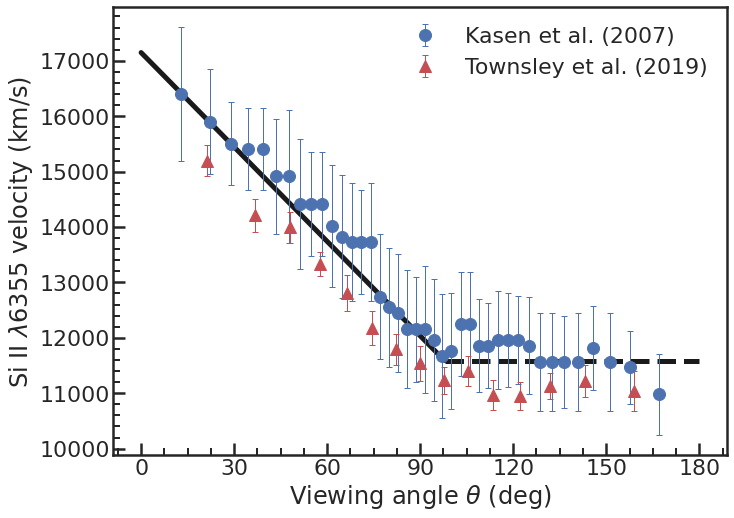

In [17]:
params, _ = curve_fit(piecewise_linear, np.concatenate([kasen_model['viewing_angle'], townsley_model['viewing_angle']]), np.concatenate([kasen_model['v_siII'], townsley_model['v_siII']]), p0=[100, 12000, -4000/60])

x = np.linspace(0, 180,1000)
fig = plt.figure(figsize=(10, 7))

plt.errorbar(kasen_model['viewing_angle'], kasen_model['v_siII'], yerr=kasen_model['v_siII_err'], 
             fmt='o', elinewidth=1, capsize=3, capthick=1, zorder=2, label='Kasen et al. (2007)')
plt.errorbar(townsley_model['viewing_angle'], townsley_model['v_siII'], yerr=townsley_model['v_siII_err'], 
             fmt='^', elinewidth=1, capsize=3, capthick=1, color='r', zorder=2, label='Townsley et al. (2019)')
plt.plot(x[x <= params[0]], piecewise_linear(x, *params)[x <= params[0]], color='k', lw=5, zorder=1)
plt.plot(x[x > params[0]], piecewise_linear(x, *params)[x > params[0]], color='k', lw=5, zorder=1, ls='--')

# Plot config
plt.xticks(np.arange(0, 190, 30))
plt.xlabel(r'Viewing angle $\theta$ (deg)')
plt.ylabel('Si II $\lambda$6355 velocity (km/s)')
plt.tight_layout(pad=0)
plt.legend(frameon=False, fontsize=22)

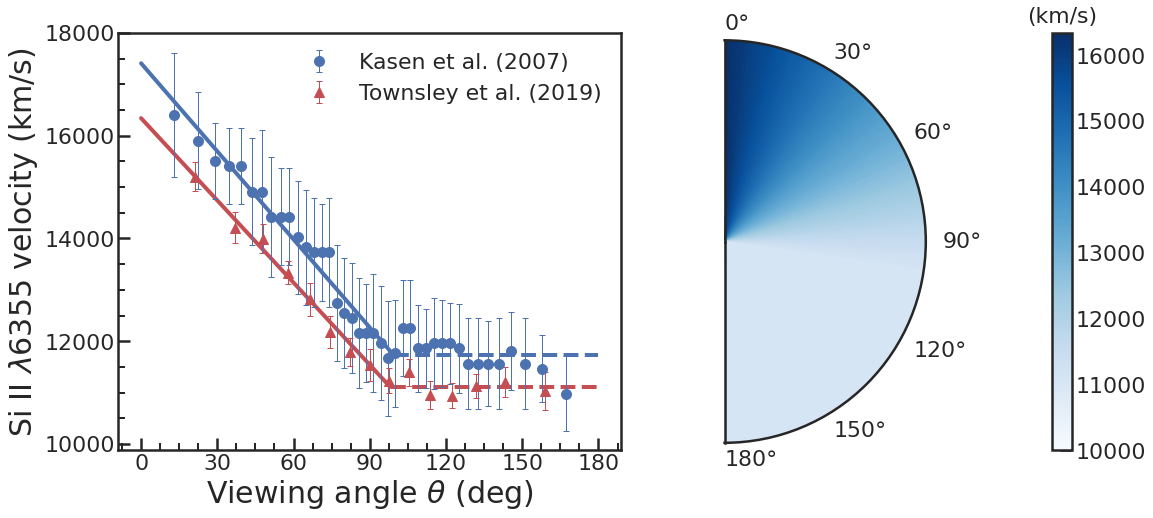

In [18]:
x = np.linspace(0, 180, 1000)
fig = plt.figure(figsize=(16, 7))

# Kasen et al. (2007)
ax = plt.subplot(121)
ax.errorbar(kasen_model['viewing_angle'],
             kasen_model['v_siII'],
             yerr=kasen_model['v_siII_err'],
             fmt='o',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             zorder=2,
             label='Kasen et al. (2007)')
params, _ = curve_fit(piecewise_linear,
                      kasen_model['viewing_angle'],
                      kasen_model['v_siII'],
                      sigma=kasen_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
ax.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='b',
         lw=4,
         zorder=1)
ax.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='b',
         lw=4,
         zorder=1,
         ls='--')

# Townsley et al. (2019)
ax.errorbar(townsley_model['viewing_angle'],
             townsley_model['v_siII'],
             yerr=townsley_model['v_siII_err'],
             fmt='^',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             color='r',
             zorder=2,
             label='Townsley et al. (2019)')
params, _ = curve_fit(piecewise_linear,
                      townsley_model['viewing_angle'],
                      townsley_model['v_siII'],
                      sigma=townsley_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
ax.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='r',
         lw=4,
         zorder=1)
ax.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='r',
         lw=4,
         zorder=1,
         ls='--')

# Plot config
ax.set_xticks(np.arange(0, 190, 30))
ax.set_yticks(np.arange(10000, 18001, 2000))
ax.set_yticklabels(np.arange(10000, 18001, 2000))
ax.set_xlabel(r'Viewing angle $\theta$ (deg)', fontsize=30)
ax.set_ylabel('Si II $\lambda$6355 velocity (km/s)', fontsize=30)
ax.legend(frameon=False, fontsize=22)

ax = plt.subplot(122, projection='polar')
x = np.arange(0, 180+1, 1)
v = np.append(piecewise_linear(x, *params)[x <= params[0]], piecewise_linear(x, *params)[x > params[0]])
theta = np.linspace(0, np.pi, len(v))
r = [0,1]
z = [v]

norm = mpl.colors.Normalize(np.min(v), np.max(v))
pc = ax.pcolormesh(theta, r, z, cmap='Blues', norm=norm, vmin=10000)

cbar = fig.colorbar(pc)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_title('(km/s)', fontsize=22, pad=10)

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
plt.yticks([])
plt.xticks(np.deg2rad(np.arange(0, 181, 30)), ha='left')
# , [f"${deg}^\circ$" if deg is not None else "" for deg in [0, None, None, 90, None, None, 180]]
plt.xlim(0, np.pi)

ax.tick_params(axis='x', which='major', pad=10)

plt.tight_layout(pad=0)

plt.savefig(
    'results/viewing_angle_plot.png',
    orientation='landscape',
    format='png',
    dpi=600
)

# Asymmetry Models

Assumptions:

* Velocity of the Si II as a function of line of sight $\theta$ around the photosphere is inspired by the results of [2] and [3] which supports a monotonic decrease of velocity from its maximum (chosen to be at $\theta = 0$)

* velocity are symmetric along one axis where $v(\theta) = v(-\theta)$.

* We make the simplify the monotonic decrease to be linear in addition to a cutoff at some angle $\theta_c$ such that,

    $$
    v(\theta) = \begin{cases} v_c + \dfrac{\theta_c - \theta}{\theta_c}\Delta v & \theta\le\theta_c \\ 
    v_c & \theta\gt\theta_c\end{cases}
    $$
    
    Where $v_c$ is distributed from the group I Gaussian component fit of the data and $\Delta v$ and $\theta_c$ are treated as free parameters.
    
Using the simulation above, the best estimated parameters is determined by a grid search amongst all two parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\theta  &\in \text{range}(0, 180, 5) \quad \text{[deg]}\\
\Delta v &\in \text{range}(3000,~ 7500,~ 500) \quad \mathrm{[km~s^{-1}]}
\end{align}
$$

In total, 324 sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test.


2. [Kasen D. and Plewa T. 2007](https://iopscience.iop.org/article/10.1086/516834)
3. [Townsley, D. M., Miles, B. J., Shen, K. J. et al. 2019](https://iopscience.iop.org/article/10.3847/2041-8213/ab27cd)

## Case 1: One Spherical and One Asymmetric

In [19]:
import pickle as pkl

# See grid_search.py::model_v2 for simulation implementation
with open('results/scores_v2.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
argsort = np.argsort(ks)

pvalue = scores['pvalue']
pvalue = pvalue[argsort]
ks = ks[argsort]

params = scores['params'][argsort]
v_sim = scores['v_sim'][argsort]

df = pd.DataFrame([
    ks, pvalue, [param['theta']
                 for param in params], [param['delta_v'] for param in params]
],
                  index=['ks', 'pvalue', 'theta', 'delta_v']).T

df.head()

,ks,pvalue,theta,delta_v
0,0.032481,0.899131,110.0,6500.0
1,0.032633,0.896029,111.0,6300.0
2,0.032881,0.890843,112.0,5700.0
3,0.032973,0.888902,110.0,6400.0
4,0.032993,0.888476,113.0,5600.0


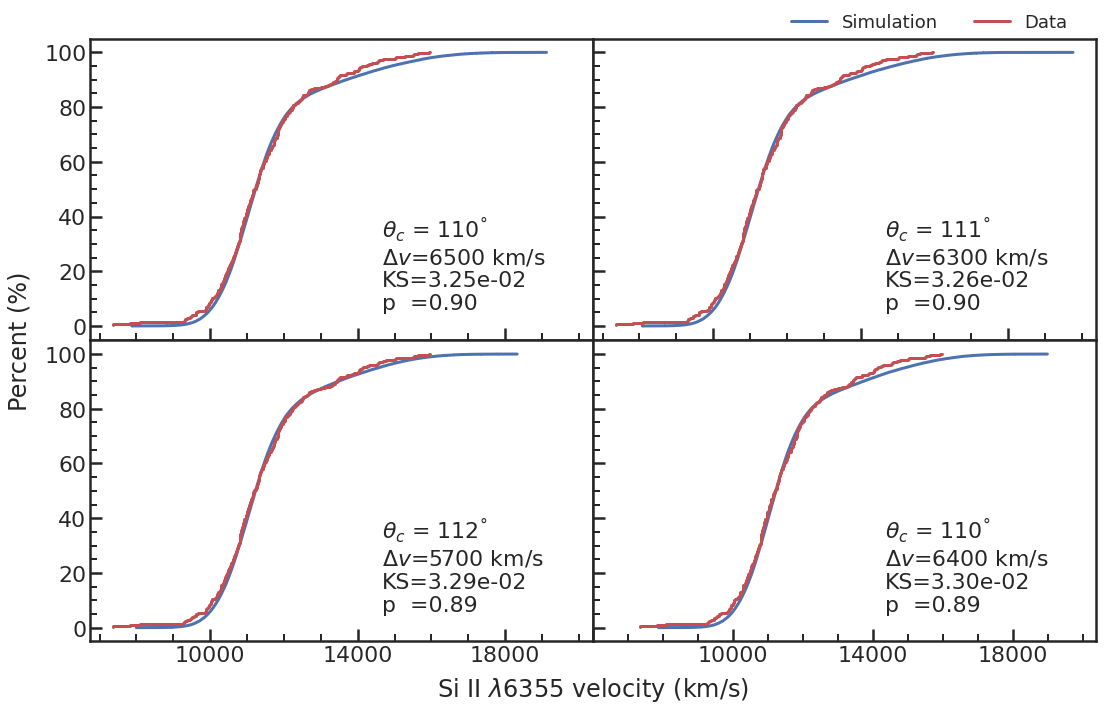

In [20]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)


for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

#     ax.hist(data['v_siII'], density=True, bins=np.linspace(6000, 20000, len(np.sort(data['v_siII']))), histtype='step', cumulative=True, label='Data')
#     ax.hist(v_sim[i], density=True, bins=np.sort(v_sim[i]), color='r', histtype='step', cumulative=True, label='Simulation')
    
    _x = np.sort(v_sim[i])
    ax.plot(_x, np.arange(1, len(_x)+1)/len(_x)*100, 
            drawstyle='steps', linewidth=3, label='Simulation')
    
    _x = np.sort(data['v_siII'])
    ax.step(_x, np.arange(1, len(_x)+1)/len(_x)*100, 
            drawstyle='steps', linewidth=3, color='r', label='Data')
    
    # Textbox for paramters
    ax.text(x=0.58, y=0.10,
        s=f"$\\theta_c$ = {param['theta']}$^\degree$\n$\Delta v$={param['delta_v']} km/s\nKS={ks[i]:.2e}\np  ={pvalue[i]:.2f}", 
        horizontalalignment="left", fontsize=22, transform=ax.transAxes)
    
    xticks = np.arange(6000, 20001, 4000)
    ax.set_xticks(xticks)
    ax.set_xticklabels([None] + list(xticks[1:]))

# Outer plot
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II $\lambda$6355 velocity (km/s)', labelpad=10)
plt.ylabel("Percent (%)", labelpad=20)
plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.69, 1), frameon=False, ncol=2, fontsize=18)

plt.tight_layout(pad=0)
plt.savefig('results/grid_search_cumulative_results_v2.eps', format='eps', dpi=800)

In [21]:
with open('results/all_scores_v2.pkl', 'rb') as f:
    all_scores = pkl.load(f)

params = all_scores.pop('params')
df = pd.DataFrame(all_scores)
df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.193751,1.555419e-10,0,3000
1,0.193711,1.570439e-10,1,3000
2,0.193701,1.574216e-10,2,3000
3,0.193601,1.612479e-10,3,3000
4,0.193591,1.616355e-10,4,3000


To develop a confidence interval for the parameters $\theta$ and $\Delta_v$, we need something similar to the likelihood or posterior probability distribution. We can take a look at the parameter's p-value distribution, however, much proof is needed to show that p-value distribution is similar to a likelihood distribution, that is, the p-value proportional to chance of observing the data given the model parameters.

Text(0, 0.5, 'Probability')

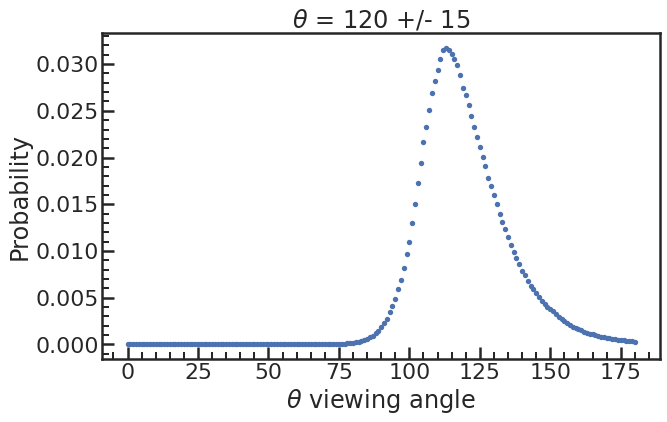

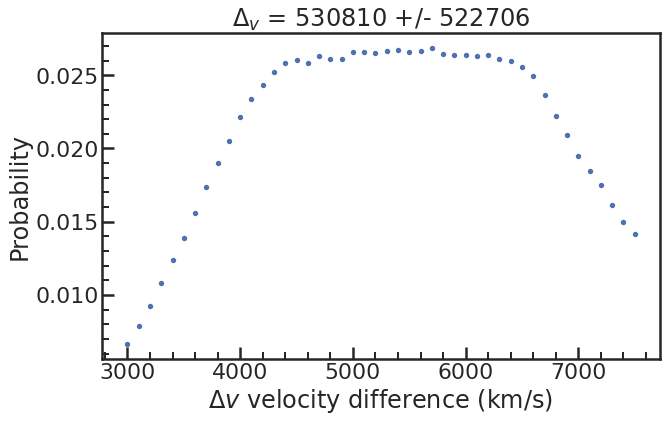

In [22]:
theta = df.groupby(['theta']).agg('sum')[['pvalue']]
theta['p'] =  theta['pvalue'] / theta['pvalue'].sum()

plt.figure()
x = theta.index
y = theta['p']
plt.scatter(x, y, s=10)

mean = np.trapz(y*x, x)
sd = np.sqrt(np.trapz(y * (x-mean)**2))
mean, sd
plt.title(f"$\\theta$ = {mean:.0f} +/- {sd:.0f}");
plt.xlabel(r'$\theta$ viewing angle')
plt.ylabel('Probability')

###

delta_v = df.groupby(['delta_v']).agg('sum')[['pvalue']]
delta_v['p'] =  delta_v['pvalue'] / delta_v['pvalue'].sum()

plt.figure()
x = delta_v.index
y = delta_v['p']
plt.scatter(x, y, s=10)

mean = np.trapz(y*x, x)
sd = np.sqrt(np.trapz(y * (x-mean)**2))
mean, sd
plt.title(f"$\\Delta_v$ = {mean:.0f} +/- {sd:.0f}");
plt.xlabel(r'$\Delta v$ velocity difference (km/s)')
plt.ylabel('Probability')

Text(0, 0.5, 'Count')

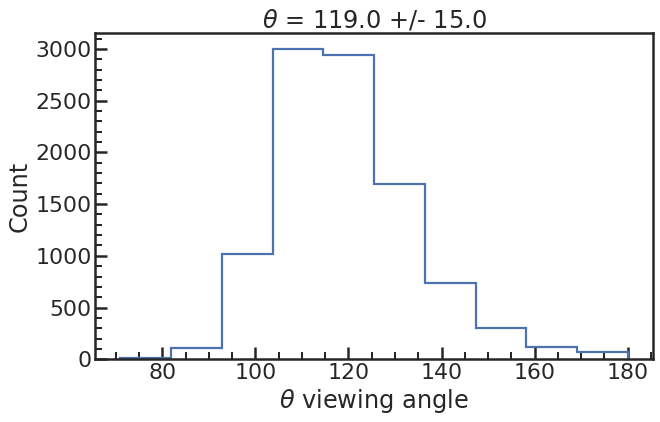

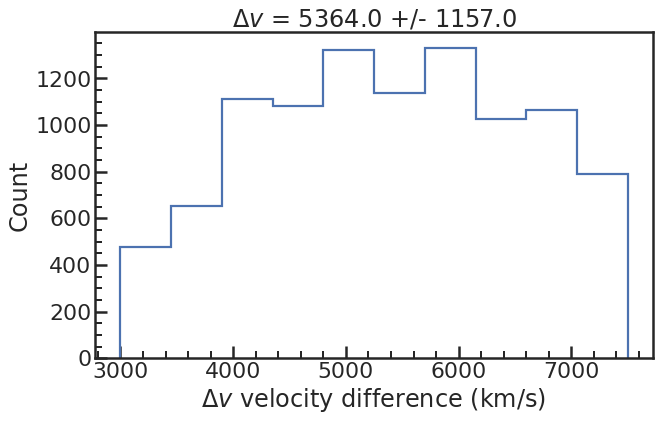

In [23]:
random_idx = np.random.choice(df.index, p=df['pvalue'] / df['pvalue'].sum(), size=10000)
sample = df.loc[random_idx, ['theta', 'delta_v']]


plt.figure()
_x = sample['theta']
plt.hist(_x, histtype='step')
plt.title(f"$\\theta$ = {np.round(np.mean(_x), 0)} +/- {np.round(np.std(_x), 0)}")
plt.xlabel(r'$\theta$ viewing angle')
plt.ylabel('Count')

plt.figure()
_x = sample['delta_v']
plt.hist(_x, histtype='step')
plt.title(f"$\Delta v$ = {np.round(np.mean(_x))} +/- {np.round(np.std(_x))}")
plt.xlabel(r'$\Delta v$ velocity difference (km/s)')
plt.ylabel('Count')

## Case 2: All Asymmetric

In [24]:
import pickle as pkl

# See grid_search.py::model_v3 for simulation implementation
with open('results/scores_v3.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
argsort = np.argsort(ks)

pvalue = scores['pvalue']
pvalue = pvalue[argsort]
ks = ks[argsort]

params = scores['params'][argsort]
v_sim = scores['v_sim'][argsort]

df = pd.DataFrame([
    ks, pvalue, [param['theta']
                 for param in params], [param['delta_v'] for param in params]
],
                  index=['ks', 'pvalue', 'theta', 'delta_v']).T

df.head()

,ks,pvalue,theta,delta_v
0,0.032373,0.901323,59.0,6900.0
1,0.032901,0.890420,59.0,6800.0
2,0.032953,0.889328,60.0,6600.0
3,0.033173,0.884605,60.0,6700.0
4,0.033623,0.874660,60.0,6300.0


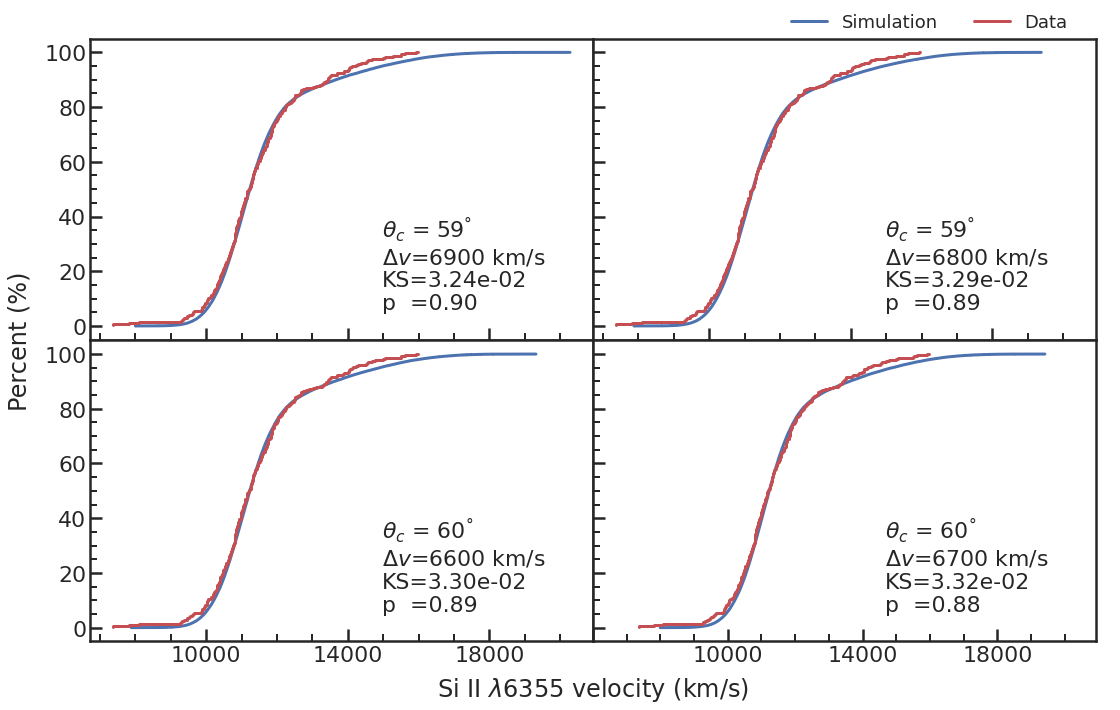

In [25]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)


for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

#     ax.hist(data['v_siII'], density=True, bins=np.linspace(6000, 20000, len(np.sort(data['v_siII']))), histtype='step', cumulative=True, label='Data')
#     ax.hist(v_sim[i], density=True, bins=np.sort(v_sim[i]), color='r', histtype='step', cumulative=True, label='Simulation')
    
    _x = np.sort(v_sim[i])
    ax.plot(_x, np.arange(1, len(_x)+1)/len(_x)*100, 
            drawstyle='steps', linewidth=3, label='Simulation')
    
    _x = np.sort(data['v_siII'])
    ax.step(_x, np.arange(1, len(_x)+1)/len(_x)*100, 
            drawstyle='steps', linewidth=3, color='r', label='Data')
    
    # Textbox for paramters
    ax.text(x=0.58, y=0.10,
        s=f"$\\theta_c$ = {param['theta']}$^\degree$\n$\Delta v$={param['delta_v']} km/s\nKS={ks[i]:.2e}\np  ={pvalue[i]:.2f}", 
        horizontalalignment="left", fontsize=22, transform=ax.transAxes)
    
    xticks = np.arange(6000, 20001, 4000)
    ax.set_xticks(xticks)
    ax.set_xticklabels([None] + list(xticks[1:]))

# Outer plot
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II $\lambda$6355 velocity (km/s)', labelpad=10)
plt.ylabel("Percent (%)", labelpad=20)
plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.69, 1), frameon=False, ncol=2, fontsize=18)

plt.tight_layout(pad=0)
plt.savefig('results/grid_search_cumulative_results_v3.eps', format='eps', dpi=800)

In [26]:
with open('results/all_scores_v3.pkl', 'rb') as f:
    all_scores = pkl.load(f)

params = all_scores.pop('params')
df = pd.DataFrame(all_scores)
df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.193751,1.555419e-10,0,3000
1,0.193711,1.570439e-10,1,3000
2,0.193681,1.581797e-10,2,3000
3,0.193431,1.679625e-10,3,3000
4,0.193171,1.787644e-10,4,3000


Text(0, 0.5, 'Probability')

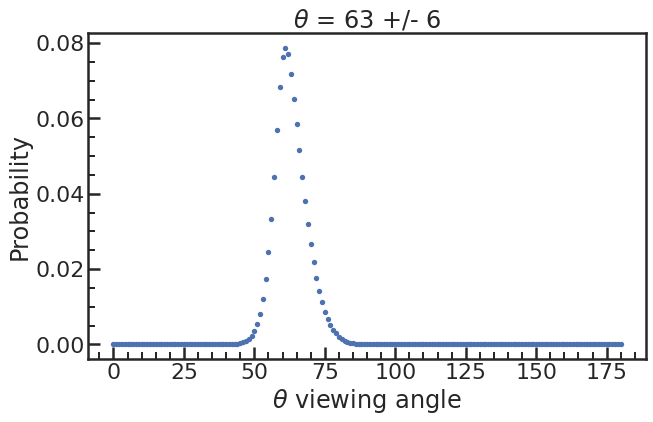

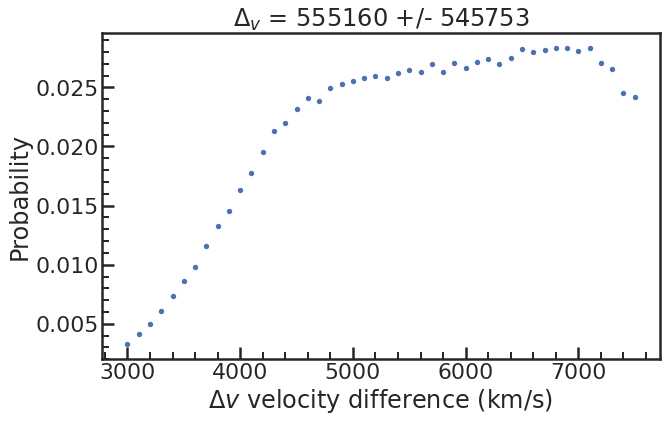

In [27]:
theta = df.groupby(['theta']).agg('sum')[['pvalue']]
theta['p'] =  theta['pvalue'] / theta['pvalue'].sum()

plt.figure()
x = theta.index
y = theta['p']
plt.scatter(x, y, s=10)

mean = np.trapz(y*x, x)
sd = np.sqrt(np.trapz(y * (x-mean)**2))
mean, sd
plt.title(f"$\\theta$ = {mean:.0f} +/- {sd:.0f}");
plt.xlabel(r'$\theta$ viewing angle')
plt.ylabel('Probability')

###

delta_v = df.groupby(['delta_v']).agg('sum')[['pvalue']]
delta_v['p'] =  delta_v['pvalue'] / delta_v['pvalue'].sum()

plt.figure()
x = delta_v.index
y = delta_v['p']
plt.scatter(x, y, s=10)

mean = np.trapz(y*x, x)
sd = np.sqrt(np.trapz(y * (x-mean)**2))
mean, sd
plt.title(f"$\\Delta_v$ = {mean:.0f} +/- {sd:.0f}");
plt.xlabel(r'$\Delta v$ velocity difference (km/s)')
plt.ylabel('Probability')

Text(0, 0.5, 'Count')

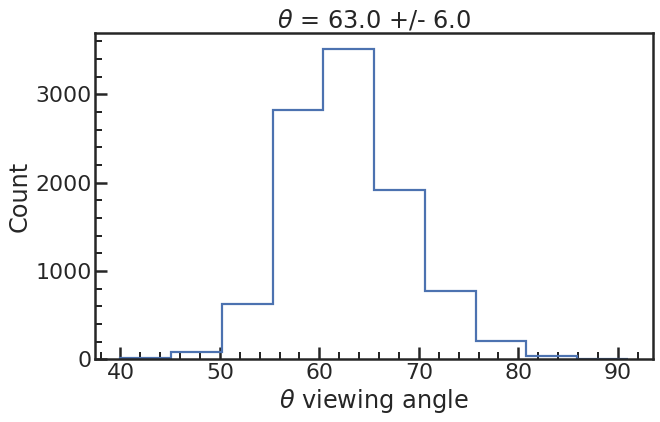

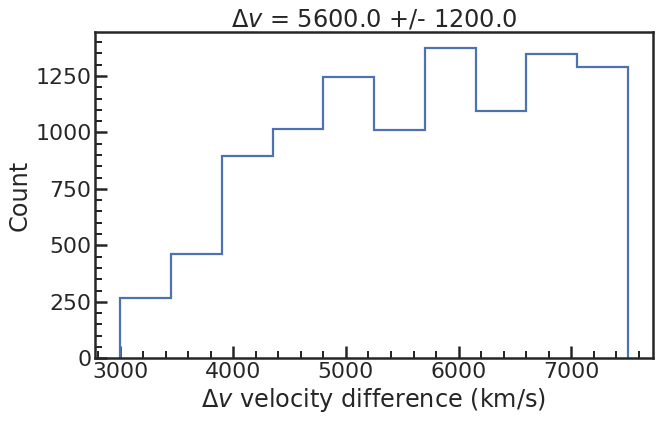

In [28]:
random_idx = np.random.choice(df.index, p=df['pvalue'] / df['pvalue'].sum(), size=10000)
sample = df.loc[random_idx, ['theta', 'delta_v']]


plt.figure()
_x = sample['theta']
plt.hist(_x, histtype='step')
plt.title(f"$\\theta$ = {np.round(np.mean(_x), 0)} +/- {np.round(np.std(_x), 0)}")
plt.xlabel(r'$\theta$ viewing angle')
plt.ylabel('Count')

plt.figure()
_x = sample['delta_v']
plt.hist(_x, histtype='step')
plt.title(f"$\Delta v$ = {np.round(np.mean(_x), -2)} +/- {np.round(np.std(_x), -2)}")
plt.xlabel(r'$\Delta v$ velocity difference (km/s)')
plt.ylabel('Count')

# Appendix

## Selection Bias Analysis

In [29]:
data = import_kaepora()
data = data[~data['z'].isna()]
data.head()

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


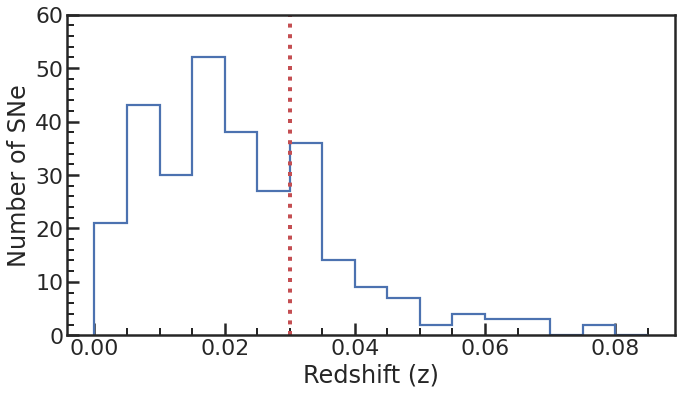

In [30]:
z_cutoff = 0.03

bins = np.arange(0, 9, 0.5) / 100
plt.hist(data['z'], bins=bins, histtype='step')
plt.vlines(z_cutoff, 0, 60, color='r', linestyle='dotted', linewidth=4)

plt.ylim(0, 60)
plt.xlabel('Redshift (z)')
plt.ylabel('Number of SNe')

plt.tight_layout()
plt.savefig('results/z_histogram.eps', orientation='landscape', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


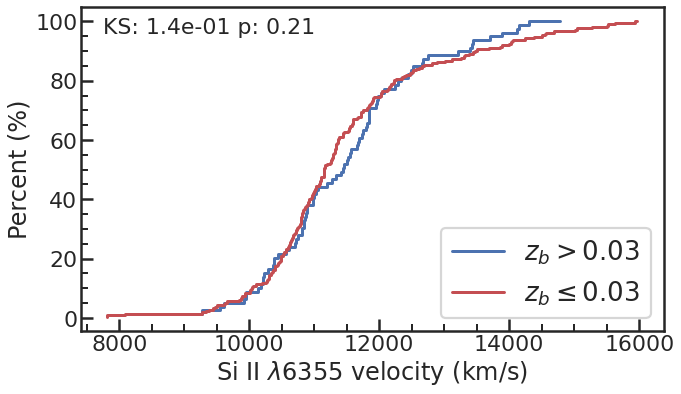

In [31]:
from scipy import stats
z_cutoff = 0.03
ks = stats.ks_2samp(data['v_siII'][data['z'] > z_cutoff], data['v_siII'][data['z'] <= z_cutoff])
bins = np.arange(7000, 16001, 500)

x = data['v_siII'][data['z'] > z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$z_b > {z_cutoff:.2g}$')

x = data['v_siII'][data['z'] <= z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$z_b \leq {z_cutoff:.2g}$')

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=26)

plt.tight_layout()
plt.savefig('results/z_03_ks_test.eps', orientation='landscape', format='eps')

In [32]:
z_cutoffs = [0.01, 0.02, 0.03, 0.04]
bins = np.arange(7000, 16001, 500)

results = []
for z_cutoff in z_cutoffs:
    sample_greater = data['v_siII'][data['z'] > z_cutoff]
    sample_lesser = data['v_siII'][data['z'] <= z_cutoff]
    
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    results.append({
        '$z_b$': z_cutoff,
        'ks': ks_test[0],
        'pvalue': ks_test[1],
        'size ($>z_b$)': len(sample_greater),
        'size ($\le z_b$)': len(sample_lesser),
    })
    
pd.DataFrame(results)

,$z_b$,ks,pvalue,size ($>z_b$),size ($\le z_b$)
0,0.01,0.125482,0.374987,227,64
1,0.02,0.153912,0.054884,144,147
2,0.03,0.136912,0.207019,79,212
3,0.04,0.129502,0.706240,30,261


In [33]:
z_left = 0.01
z_right = 0.04
bins = np.arange(7000, 16001, 500)

sample_greater = data['v_siII'][data['z'] > z_right]
sample_lesser = data['v_siII'][data['z'] <= z_left]

ks_test = stats.ks_2samp(sample_greater, sample_lesser)
results = {
    'ks': ks_test[0],
    'pvalue': ks_test[1],
    f'size ($z>{z_right}$)': len(sample_greater),
    f'size ($\le{z_left}$)': len(sample_lesser),
}

pd.DataFrame([results.values()], columns=results.keys())

,ks,pvalue,size ($z>0.04$),size ($\le0.01$)
0,0.159375,0.608851,30,64


## Sampling a Uniform Sphere from 3D to 2D

For a uniformly distributed sphere in 3D, the projection down to 2D on the x-z plane where $\phi$ (the colongitude angle) disappears, the probability distribution as a function of $\theta$ (the colatitude angle) is,

$$
P(\theta) = \frac{1}{2} \sin{\theta}
$$

Sampling this distribution requires a trick where we take the uniform random variable $U ~ [0,1]$ and apply the transformation:

$$
u \in U\\
\theta = \arccos(2u - 1)
$$

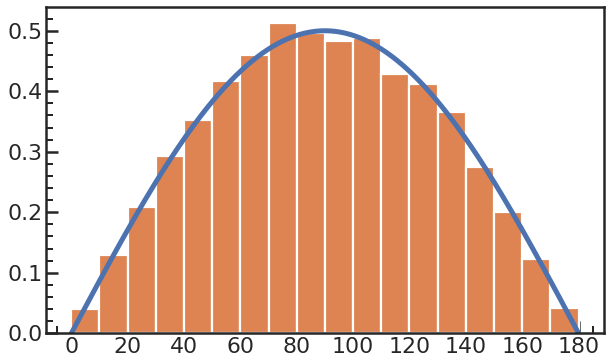

In [34]:
def pdf(theta):
    return -np.sin(theta) / 2


# Plot the true PDF
theta = np.linspace(0, np.pi, 10000)

# Sample with special trick
v = np.random.uniform(0, 1, 10000)
theta_samples = np.arccos(2 * v - 1)
# theta_samples = np.pi/2 - theta_samples
# theta_samples[theta_samples < 0] = theta_samples[theta_samples < 0]

bins = np.radians(np.arange(0, 181, 10))
plt.plot(theta, np.abs(pdf(theta)))
plt.hist(theta_samples, density=True, bins=bins)
plt.xticks(ticks=bins[::2],
           labels=[f"{xtick/np.pi * 180:.0f}" for xtick in bins[::2]])